<html><font size=6><B>3η εργαστηριακή άσκηση</B><BR>
    <BR><B>Link prediction - Πρόβλεψη συνδέσμων</B></BR>
    </font></html>

<html><font size=4><B>1. Κατασκευή γράφου και προεργασία για την πρόβλεψη συνδέσμων</B></font>
    <li><B>1(i).</B> Χρησιμοποιήστε το dataset <a href="http://konect.cc/networks/dbpedia-similar/"> Similarities (DBpedia)</a>, για να κατασκευάσετε τον μη κατευθυνόμενο (undirected) γράφο $G$ <a href="https://dl.acm.org/doi/10.1145/2487788.2488173">[1]</a>,<a href="https://link.springer.com/chapter/10.1007/978-3-540-76298-0_52">[2]</a>. Οι κόμβοι του γράφου αναπαριστούν σελίδες της Wikipedia και οι ακμές σχέση ομοιότητας μεταξύ τους. Στην σελίδα <a href="http://konect.cc/networks/dbpedia-similar/"> KONECT (DBpedia)</a> μπορείτε να βρείτε πληροφορίες για τις ιδιότητες του γράφου.</a><BR>
        <B><U>Υπόδειξη:</U></B> Μπορείτε να ελέγξετε προγραμματιστικά αν το dataset περιέχει διπλότυπα των ακμών με την ίδια ή αντίστροφη σειρά (π.χ. ακμές (a,b) και (b,a)), και να λάβετε υπ' όψιν σας αυτήν σας την παρατήρηση, όπου τυχόν χρειαστεί, στην ερώτηση 2.<BR></html>

In [1]:

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

edges = set()
duplicates = set()

# Open the file for reading
with open('./dbpedia-similar/out.dbpedia-similar', 'r') as f:
    # Iterate over the lines in the file
    for line in f:
        # Split the line into two parts
        parts = line.split()
        # Convert the parts to integers
        from_node = int(parts[0])
        to_node = int(parts[1])
        # Add the edge to the set, with the nodes sorted in ascending order
        edge = tuple(sorted((from_node, to_node)))
        if edge in edges:
            duplicates.add(edge)
        else:
            edges.add(edge)

if len(duplicates) == 0:
    print("No duplicate edges found")
else:
    # Print the duplicate edges
    print("Duplicate edges:", duplicates)


# Create a graph from the edges
G = nx.read_edgelist('./dbpedia-similar/out.dbpedia-similar', create_using=nx.Graph())
print(G)
 



No duplicate edges found
Graph with 430 nodes and 565 edges


 <li><B>1(ii).</B> Εμφανίστε τον αριθμό των κόμβων, τον αριθμό των ακμών, τον μέσο βαθμό των κόμβων και τον αριθμό των συνεκτικών συνιστωσών (connected components) για τον γράφο $G$.</li><BR>

In [2]:

def graph_stats(G):
    node_count= len(G.nodes())
    edge_count= len(G.edges())
    degree_avg = sum(nx.degree_centrality(G).values()) / node_count
    number_of_connected_components = nx.number_connected_components(G)

    return node_count, edge_count, degree_avg, number_of_connected_components

initial_node_count, initial_edge_count, initial_degree_avg, initial_number_of_connected_components = graph_stats(G)

print("Initial graph stats:")
print("Number of nodes: ", initial_node_count)
print("Number of edges: ", initial_edge_count)
print("Average degree: ", initial_degree_avg)
print("Number of connected components: ", initial_number_of_connected_components)



Initial graph stats:
Number of nodes:  430
Number of edges:  565
Average degree:  0.0061256572884480125
Number of connected components:  95


<li><B>1(iii). </B>Υπολογίστε το σύνολο των ασύνδετων ζευγών κόμβων (unconnected pairs) στον γράφο χρησιμοποιώντας τον πίνακα γειτνίασης (adjacency matrix). Δώστε επίσης τον αριθμό τους. Λάβετε υπ' όψιν σας ότι ο γράφος είναι μη κατευθυνόμενος και δεν χρειάζεται να διατρέξετε ολόκληρο τον πίνακα γειτνίασης.</li><BR>

In [3]:

def find_unconnected(G):
    # Get the adjacency matrix of the graph
    adj_matrix = nx.adjacency_matrix(G)
    # Convert the matrix to a dense NumPy array
    adj_array = adj_matrix.toarray()
    # Create an empty list to store the unconnected pairs
    unconnected = []
    # Iterate over the rows and columns of the array
    for i in range(adj_array.shape[0]):
        for j in range(adj_array.shape[1]):
            # If the element is 0 and the row index is less than the column index, add the corresponding pair of nodes to the list
            if adj_array[i, j] == 0 and i < j:
                unconnected.append((str(i+1), str(j+1)))
    # Return the list of unconnected pairs
    return unconnected

unconnected_pairs = find_unconnected(G)

print("Number of unconnected pairs: ", len(find_unconnected(G)))



Number of unconnected pairs:  91671


<li><B>1(iv).</B> Υπολογίστε το σύνολο των ακμών (removable edges) που μπορούν να αφαιρεθούν από τον γράφο χωρίς να υπάρχει κατάτμηση (splitting) του γράφου (δηλ. ο αριθμός των συνεκτικών συνιστωσών θα πρέπει να παραμένει αμετάβλητος). Υπόδειξη: Ελέγχετε επίσης ότι με αφαίρεση ακμής δεν μειώνεται ο αριθμός των κόμβων (εφόσον δεν υπάρχει ξεχωριστό αρχείο μόνο με κόμβους στο dataset). Δώστε επίσης τον αριθμό των ακμών (removable edges) που μπορούν να αφαιρεθούν υπό αυτές τις προϋποθέσεις.</li><BR>

In [4]:
removable_edges = list()
copy_of_G = G.copy()
for edge in G.edges():
    # remove the edge from the copy of the graph
    copy_of_G.remove_edge(*edge)
    # check if the number_connected_components remains the same and the number of nodes is the same. Also we removed the self-loops
    if (nx.number_connected_components(copy_of_G) == initial_number_of_connected_components and len(copy_of_G.nodes()) == initial_node_count) and edge[0] != edge[1]:
        # add the edge to the set of removable edges
        removable_edges.append(edge)
    else:
        # add the edge back to the graph
        copy_of_G.add_edge(*edge)


print("Number of removable edges in the graph: ", len(removable_edges))

Number of removable edges in the graph:  229


<li><B>1(vα).</B> Κατασκευάστε dataframe που συνενώνει τις απαντήσεις των ερωτημάτων 1(iii) και 1(iv) (unconnected+removables). Χρησιμοποιήστε την μεταβλητή $link$ που θα παίρνει τιμή 1 ή 0 ανάλογα με την ύπαρξη συνδέσμου ή μη. To dataframe αυτό συγκεντρώνει τα θετικά και αρνητικά δείγματα για την πρόβλεψη των μελλοντικών συνδέσεων (link: target variable). <BR>
    <li><B>1(vβ).</B> Κατασκευάστε τον γράφο $G'$ που προκύπτει από την αφαίρεση από τον γράφο $G$ των ακμών του ερωτήματος 1(iv). <BR>
    <li><B>1(vγ).</B> Εμφανίστε τον αριθμό των κόμβων, τον αριθμό των ακμών, τον μέσο βαθμό των κόμβων και τον αριθμό των συνεκτικών συνιστωσών (connected components) για τον γράφο $G'$.</li><BR>

In [5]:
# create a dataframe with removable edges
df_removable_edges = pd.DataFrame(removable_edges, columns=['node1', 'node2'])
df_removable_edges['link'] = 1

# create a dataframe with unconnected pairs
df_unconnected = pd.DataFrame(unconnected_pairs, columns=['node1', 'node2'])
df_unconnected['link'] = 0

#merge in one dataframe
df_removable_unconnected = pd.concat([df_removable_edges, df_unconnected], ignore_index=True)

#build graph G'= G - removable_edges
G_reduced = G.copy()
G_reduced.remove_edges_from(removable_edges)

G_reduced_node_count, G_reduced_edge_count, G_reduced_degree_avg, G_reduced_number_of_connected_components = graph_stats(G_reduced)

print("New graph stats:")
print("Number of nodes: ", G_reduced_node_count)
print("Number of edges: ", G_reduced_edge_count)
print("Average degree: ", G_reduced_degree_avg)
print("Number of connected components: ", G_reduced_number_of_connected_components)



New graph stats:
Number of nodes:  430
Number of edges:  336
Average degree:  0.0036428687591478492
Number of connected components:  95


<html><font size=4><B>2. Εισαγωγή σε similarity-based μετρικές για Link prediction</B></font><BR><BR>
     <li> Η μετρική <B>Jaccard Coefficient (JC)</B> των κόμβων ${u}$ και ${v}$ ορίζεται ως $\frac{|\Gamma(u) \cap \Gamma(v)|}{|\Gamma(u) \cup \Gamma(v)|}$, όπου ${\Gamma(u)}$ είναι το σύνολο των γειτονικών κόμβων του κόμβου ${u}$.  <B></B>
        <li> Η μετρική <B>Preferential Αttachment (PA)</B> των κόμβων $u$ και $v$ ορίζεται ως $|\Gamma(u)| |\Gamma(v)|$, όπου $\Gamma(u)$ είναι το σύνολο των γειτονικών κόμβων του $u$.</li>
        <li> Η μετρική <B>Resource Allocation (RA)</B> των κόμβων $u$ και $v$ ορίζεται ως $\sum_{w \in \Gamma(u) \cap \Gamma(v)} \frac{1}{|\Gamma(w)|}$, όπου $\Gamma(u)$ είναι το σύνολο των γειτονικών κόμβων του $u$.</li><BR><BR>
    <li><B>2(i).</B> Για τον γράφο $G'$, που κατασκευάσατε στο ερώτημα 1(vβ), υπολογίστε την μετρική <B>Jaccard Coefficient (JC)</B>.  <u><a href="https://networkx.org/documentation/stable/reference/algorithms/link_prediction.html?highlight=link%20prediction">Χρησιμοποιήστε την υλοποιημένη συνάρτηση του λογισμικού NetworkX.<a></u> <BR><BR>
    <li><B>2(ii). </B>Δώστε τις $k$ ακμές με την υψηλότερη τιμή μετρικής $JC$, όπου $k$ ο $Α.Μ.$ σας $mod$ $10$. Για $Α.Μ.$ λήγοντα σε $0$ δώστε τις $10$ ακμές με την υψηλότερη τιμή μετρικής.
        (Για την σύγκριση μεταξύ διαφορετικών μετρικών προτιμάται η εύρεση των $k$ επικρατέστερων συνδέσμων, αφού οι μετρικές επιστρέφουν διαφορετικό εύρος τιμών.)</li><BR>
    <li><B>2(iii). </B>Προσδιορίστε για την μέτρηση της απόδοσης της μετρικής $JC$ τα μεγέθη $Precision$, $Recall$ και $Accuracy$ και αναπαραστήστε τα γραφικά για τιμές κατωφλίου: $0.1$, $0.15$, $0.25$, $0.5$, $1.0$.  <BR><BR>
    $Precision=\frac{TP}{TP+FP}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $FP$: ψευδώς θετικά αποτελέσματα <BR>
    $Recall=\frac{TP}{TP+FN}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $FN$: ψευδώς αρνητικά αποτελέσματα</li> 
    $Accuracy=\frac{TP+TN}{TP+FN+TN+FP}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $TN$: αληθώς αρνητικά αποτελέσματα, $FN$: ψευδώς αρνητικά αποτελέσματα, $FP$: ψευδώς θετικά αποτελέσματα</li><BR><BR>
        <B><U>Υπόδειξη:</U></B>
        Θετικό θεωρήστε ένα αποτέλεσμα, αν η μετρική $JC$ υπερβαίνει μια τιμή κατωφλίου (>=). Αρνητικό θεωρήστε το στην αντίθετη περίπτωση.
        <li>Αληθώς θετικά είναι τα αποτελέσματα που βγήκαν θετικά (η τιμή της $JC$ υπερβαίνει την τιμή κατωφλίου) και πράγματι θα υπάρξουν οι συνδέσεις που περιγράφουν (ερ. 1(iv)).</li>
        <li>Αληθώς αρνητικά είναι τα αποτελέσματα που βγήκαν αρνητικά και πράγματι δεν θα υπάρξουν οι συνδέσεις που περιγράφουν (ερ. 1(iii)).</li>
        <li>Ψευδώς θετικά είναι τα αποτελέσματα που βγήκαν θετικά, ενώ δεν θα υπάρξουν οι συνδέσεις που περιγράφουν.</li>
        <li>Ψευδώς αρνητικά είναι τα αποτελέσματα που βγήκαν αρνητικά, ενώ θα υπάρξουν οι συνδέσεις που περιγράφουν.</li>
        <li>Το άθροισμα $TN+FP$ πρέπει κάθε φορά να σας δίνει όλες τις ασύνδετες ακμές του γράφου $G$.</li>   
<li>Από το ερώτημα 1(iii) οι ακμές που υπολογίσατε είναι αυτές για τις οποίες δεν θα υπάρξουν συνδέσεις.</li> <li>Από το ερώτημα 1(iv) οι ακμές που υπολογίσατε είναι αυτές για τις οποίες θα υπάρξουν συνδέσεις.</li><BR></html>

Top 1 edges: [('351', '350', 1.0)]


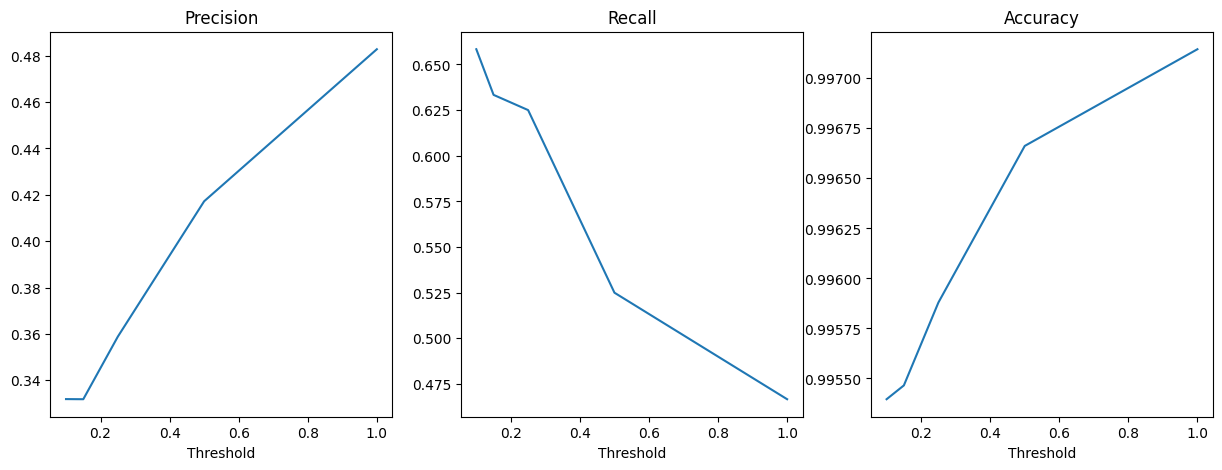

In [6]:
# 2(i).
# define a function that returns the Jaccard coefficient of a graph
def JCfunction(graph): 
    return nx.jaccard_coefficient(graph)

# 2(ii).
# ΑΜ = 18441
k = 18441%10
# sort the edges by the Jaccard coefficient
sorted_edges = sorted(JCfunction(G_reduced), key=lambda x: x[2], reverse=True)
# get the top k edges
top_k_edges = sorted_edges[:k]

print("Top {} edges:".format(k), top_k_edges) 

# 2(iii).
threshold_values = [0.1,0.15,0.25,0.5,1]

set_removable_edges = set(removable_edges)
set_unconnected_pairs = set(unconnected_pairs)

# function that returns the precision, recall and accuracy metrics for Jaccard coefficient
def metrics_JC(threshold):
    # define the true positives, false positives, false negatives and true negatives
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    # iterate over the top k edges
    for edge in sorted_edges:
        # if the edge is in the removable edges and the Jaccard coefficient is greater than the threshold, then it is a true positive
        if (edge[0], edge[1]) in set_removable_edges and edge[2] >= threshold:
            TP += 1
        # if the edge is in the set_unconnected_pairs and the Jaccard coefficient is greater than the threshold, then it is a false positive
        elif (edge[0], edge[1]) in set_unconnected_pairs and edge[2] >= threshold:
            FP += 1
        # if the edge is in the removable edges and the Jaccard coefficient is less than the threshold, then it is a false negative
        elif (edge[0], edge[1]) in set_removable_edges and edge[2] <= threshold:
            FN += 1
        # if the edge is in the set_unconnected_pairs and the Jaccard coefficient is less than the threshold, then it is a true negative
        elif (edge[0], edge[1]) in set_unconnected_pairs and edge[2] <= threshold:
            TN += 1
    

    # calculate the precision, recall and accuracy and ensure that the denominator is not 0
    if (TP + FP) != 0:
        precision = TP/(TP + FP)
    else:
        precision = 0
    if (TP + FN) != 0:
        recall = TP/(TP + FN)
    else:
        recall = 0
    if (TP + TN + FP + FN) != 0:
        accuracy = (TP + TN)/(TP + TN + FP + FN)
    else:
        accuracy = 0
    # return the precision, recall and accuracy
    return precision, recall, accuracy
   

# print the precision, recall and accuracy for each threshold
for threshold in threshold_values:
    precision, recall, accuracy = metrics_JC(threshold)


# precision graph
precision_values = []
recall_values = []
accuracy_values = []
for threshold in threshold_values:
    precision, recall, accuracy = metrics_JC(threshold)
    precision_values.append(precision)
    recall_values.append(recall)
    accuracy_values.append(accuracy)

# create a diagram with 3 subplots one for each metric 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
for ax, values, title in zip([ax1, ax2, ax3], [precision_values, recall_values, accuracy_values], ['Precision', 'Recall', 'Accuracy']):
    ax.plot(threshold_values, values)
    ax.set_title(title)
    ax.set_xlabel('Threshold')
    # ax.set_ylabel(title)

plt.show()


<html><font size=4><B>3. Πρόβλεψη συνδέσμων βάσει similarity-based μετρικών</B></font>    
        <li><B>3(i).</B> Προτείνετε μια τουλάχιστον μέθοδο, για να εξερευνήσουμε και να εκφράσουμε μέσα από τα πακέτα NumPy ή SciPy ή Pandas την συσχέτιση (correlation) μεταξύ των τιμών των μετρικών <B>Jaccard Coefficient</B>, <B>Preferential Attachment</B>, <B>Resource Allocation</B> για τον μειωμένο γράφο $G'$. Σημ.: Δεν χρειάζεται κάποια υλοποίηση, μόνο αναφορά της μεθόδου συσχέτισης και επεξήγηση της επιλογής σας.
     <li><B>3(ii).</B> Εργαστείτε πάνω σε <B><U>αντίγραφο</U></B> του dataframe που κατασκευάσατε στο ερώτημα 1(vα) (unconnected+removables). Δημιουργήστε στήλη (column) με τις ακμές του γράφου και θέστε την ως index του dataframe. Στο dataframe θα προσθέσετε ως στήλες τις τιμές των μετρικών (<B>Jaccard Coefficient</B>, <B>Preferential Attachment</B>, <B>Resource Allocation</B>) για τον μειωμένο γράφο $G'$. Οι τιμές των μετρικών μπορούν να υπολογιστούν με τις συναρτήσεις του πακέτου NetworkX.</li>   </font></html>
    
    |       | link  |Jacc.Coeff.|Pr.Attachment| Resource Allocation|
    |-------|-------|-----------|-------------|--------------------|
    |(1, 6) |  0    |  0.333333 |     32      |    0.700000        |
    |(1, 46)|  0    |  0.200000 |      8      |    0.166667        |

### Answer 3(i): ###
To find the correlation of Jaccard Coefficient, Preferential Attachment, and Resource Allocation using pandas, we will use the corr method of a pandas DataFrame. Using corr_matrix = df.corr() after putting the values of the metrics in the dataframe, we will get the correlation matrix for the columns in the DataFrame. The matrix will contain the Pearson correlation coefficient for each pair of columns. The Pearson correlation coefficient is a measure of the linear correlation between two variables. It ranges from -1 (perfect negative correlation) to 1 (perfect positive correlation).

In [7]:
# # 3(ii).

# #  copy of df_removable_unconnected
df_removable_unconnected_copy = df_removable_unconnected.copy()

#  make node1 and node2 columns as a tuple and set them as the index
df_removable_unconnected_copy['node1_node2'] = list(zip(df_removable_unconnected_copy['node1'], df_removable_unconnected_copy['node2']))
df_removable_unconnected_copy.set_index('node1_node2', inplace=True)
# drop the node1 and node2 columns
df_removable_unconnected_copy.drop(['node1', 'node2'], axis=1, inplace=True)

#Preferential Attachment
preferential_attachment = list(nx.algorithms.link_prediction.preferential_attachment(G_reduced))
pref_values = []
for u, v, p in preferential_attachment:
    pref_values.append(p)

#Resource Allocation
resource_allocation = list(nx.algorithms.link_prediction.resource_allocation_index(G_reduced))
resource_allocation_values = []
for u, v, p in resource_allocation:
    resource_allocation_values.append(p)


# Jaccard Coefficient
Jaccard_coefficient = list(nx.algorithms.link_prediction.jaccard_coefficient(G_reduced))
JC_values = []
for u, v, p in Jaccard_coefficient:
    JC_values.append(p)

# add the new colums
df_removable_unconnected_copy = df_removable_unconnected_copy.assign(Jaccard_Coefficient = JC_values, Preferential_Attatchment = pref_values, Resource_Allocation = resource_allocation_values)

print(df_removable_unconnected_copy.shape)

(91900, 4)


<li><B>3(iiiα).</B> Χρησιμοποιήστε τον Random Forest Classifier και το αντίγραφο dataframe που κατασκευάσατε στο ερώτημα 3(ii), για να προβλέψετε συνδέσεις. Συμπληρώστε στον κώδικα: τα features ($X$), την target variable ($y$) και τα ορίσματα της συνάρτησης $fit$ για το training του μοντέλου.</li>
<li><B>3(iiiβ).</B> Δώστε τις ($A.M$ $mod$ $10$) πρώτες προβλέψεις και την ακρίβεια ($accuracy$) του μοντέλου. </li>
<li><B>3(iiiγ).</B>Υπολογίστε την πιθανότητα να συνδεθούν οι κόμβοι ($1$,$47$) βάσει του μοντέλου σας. </li>  

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
 
X = df_removable_unconnected_copy.drop('link', axis=1)
y = df_removable_unconnected_copy['link']

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
classifier = RandomForestClassifier()   

from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler() 
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)


parameters = {'n_estimators' : [10,50,100], 'max_depth' : [5,10,15]} 
model = GridSearchCV(classifier, param_grid = parameters) 

In [10]:
model.fit(X_train_scaled, y_train) 

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [10, 50, 100]})

In [11]:
predictions = model.predict(X_test_scaled)
k = 18441 % 10
print("{} first predictions: {}".format(k, predictions[:k]))
accuracy = accuracy_score(y_test, predictions)
print(accuracy)

1 first predictions: [0]
0.9973340587595212


In [12]:

index = df_removable_unconnected_copy.index.get_loc(('1', '47'))
edge =  df_removable_unconnected_copy.iloc[index]
edge = edge[1:].values.reshape(1, -1)
edge = mm_scaler.transform(edge)
prediction = model.predict_proba(edge)
print("Propability of the edge being a link: {}".format(prediction[0][1]))

Propability of the edge being a link: 0.0034012815322121944


<html><font size=4><B>4. Πρόβλεψη συνδέσμων με embedding βασισμένο σε τυχαίους περιπάτους (Random Walks) </B></font><BR><BR>
    <li><B>4(i).</B> Εξάγετε τα χαρακτηριστικά (features) του γράφου $G'$, που προέκυψε από την αφαίρεση των ακμών. Για τον σκοπό αυτό χρησιμοποιήστε τον αλγόριθμο <B>Node2vec</B> <a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3]</a>. Ο αλγόριθμος αντιστοιχίζει τους κόμβους του γράφου μέσω τυχαίων περιπάτων (biased 2nd order random walks) σε ένα χώρο μικρού αριθμού διαστάσεων (low dimensional space) διατηρώντας την μεταξύ τους γειτνίαση.
        <BR>Για την επιλογή των παραμέτρων: 
            <li>p - παράμετρος τυχαίων περιπάτων p που καθορίζει την πιθανότητα “1/p” επιστροφής στον κόμβο προέλευσης (source node), </li>
                <li>q - παράμετρος τυχαίων περιπάτων q που καθορίζει την πιθανότητα  “1/q” μετακίνησης σε κόμβο μακριά από τον κόμβο προέλευσης (source node), </li>
                 <li>dimensions - πλήθος διαστάσεων των Node2Vec embeddings, </li>
                     <li>num_walks - αριθμός περιπάτων από κάθε κόμβο, </li>
                         <li>walk_length - μήκος τυχαίου περιπάτου, </li>
                             <li>window_size - μέγεθος παραθύρου context για τον αλγόριθμο Word2Vec, </li><li>num_iter - αριθμός SGD επαναλήψεων (epochs), </li>
            <li>workers - αριθμός workers για τον Word2Vec,</li>
            χρησιμοποιήστε τις τιμές:   </html>
   
                   

 |   p   |   q   | dimensions|  num_walks  |walk_length |window_size|        workers            |
 |-------|-------|-----------|-------------|------------|-----------|---------------------------|
 |  1.0  |  1.0  |  128      |     10      |    80      |     10    |multiprocessing.cpu_count()|

In [13]:
from node2vec import Node2Vec  
import multiprocessing          

node2vec_walker = Node2Vec(G_reduced,p=1.0,q=1.0,dimensions=128,num_walks=10,walk_length=80,workers = multiprocessing.cpu_count())

#train node2vec model
n2v_model = node2vec_walker.fit(window=10 , min_count=1) 

Computing transition probabilities:   0%|          | 0/430 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 2/2 [00:00<00:00, 17.60it/s]


<html><font>
    <li><B>4(ii).</B> Εφαρμόστε τον αλγόριθμο Random Forest Classifier, για να προβλέψετε τις συνδέσεις.</li><BR>
    <li><B>4(iii).</B> Υπολογίστε την ακρίβεια ($accuracy$) του μοντέλου. </li><BR></font></html>

In [14]:
#apply trained Node2Vec model on each node pair of the dataframe "unconnected+removables"
x = [(n2v_model.wv[str(i)]+n2v_model.wv[str(j)]) for i,j in zip(df_removable_unconnected['node1'], df_removable_unconnected['node2'])]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(x, y,random_state=0)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

classifier = RandomForestClassifier(max_depth=2, random_state=0) 
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.997519042437432


<html><font size=4> <B><U>Ερώτηση bonus (+10/100)</U><B>: </font>Για τους binary operators για learning των edge features με τον αλγόριθμο Node2Vec που αναφέρονται στο <a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3]</a> ((α) Average, (β) Hadamard, (γ) Weighted-L1 και (δ) Weighted-L2) τροποποιήστε τoν κώδικά σας και σημειώστε τις παρατηρήσεις σας ως προς την απόδοση του αλγορίθμου.</font></html>

In [17]:
# Average
x_Average = [(n2v_model.wv[str(i)] + n2v_model.wv[str(j)]) / 2 for i, j in zip(df_removable_unconnected['node1'], df_removable_unconnected['node2'])]

# Hadamard
x_Hadamard = [(n2v_model.wv[str(i)] * n2v_model.wv[str(j)]) for i, j in zip(df_removable_unconnected['node1'], df_removable_unconnected['node2'])]

# Weighted L1
x_L1 = [np.abs(n2v_model.wv[str(i)] - n2v_model.wv[str(j)]) for i, j in zip(df_removable_unconnected['node1'], df_removable_unconnected['node2'])]

# Weighted L2
x_L2 = [(n2v_model.wv[str(i)] - n2v_model.wv[str(j)]) ** 2 for i, j in zip(df_removable_unconnected['node1'], df_removable_unconnected['node2'])]

accuracy_List = []
# for each of the 4 methods, split the data into train and test sets and train the model and calculate the accuracy
for x in [x_Average, x_Hadamard, x_L1, x_L2]:
    X_train, X_test, y_train, y_test = train_test_split(x, y,random_state=0)
    classifier = RandomForestClassifier(max_depth=2, random_state=0) 
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracy_List.append(accuracy)

print(accuracy_List)


[0.997519042437432, 0.997519042437432, 0.997519042437432, 0.997519042437432]


<html><font size=4><B><U>Βιβλιογραφία:</U></B><BR></font>
<a href="https://dl.acm.org/doi/10.1145/2487788.2488173">[1]	Jérôme Kunegis. KONECT – The Koblenz Network Collection. In Proc. Int. Conf. on World Wide Web Companion, pages 1343–1350, 2013.</a><BR>
<a href="https://link.springer.com/chapter/10.1007/978-3-540-76298-0_52">[2]	Sören Auer, Christian Bizer, Georgi Kobilarov, Jens Lehmann, Richard Cyganiak, and Zachary Ives. DBpedia: A nucleus for a web of open data. In Proc. Int. Semant. Web Conf., pages 722–735, 2008.<BR>
<a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3] A. Grover, J. Leskovec, Node2vec: Scalable Feature Learning for Networks. ACM KDD, 2016.</a><BR>
 <a href="https://proceedings.neurips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf">[4] T.Mikolov, I.Sutskever, K.Chen, G.S.Corrado and J.Dean, Distributed representations of words and phrases and their compositionality. In NIPS, 2013.</a><BR></font></html>